# Example_Basic scorecard modeling with Scorecard-Bundle

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Download-sample-data" data-toc-modified-id="Download-sample-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download sample data</a></span></li><li><span><a href="#Handle-categorical-features-and-missing-values" data-toc-modified-id="Handle-categorical-features-and-missing-values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Handle categorical features and missing values</a></span></li><li><span><a href="#Define-feature-and-target" data-toc-modified-id="Define-feature-and-target-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Define feature and target</a></span></li></ul></li><li><span><a href="#Scorecard-Model" data-toc-modified-id="Scorecard-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scorecard Model</a></span><ul class="toc-item"><li><span><a href="#Feature-Discretization-with-ChiMerge" data-toc-modified-id="Feature-Discretization-with-ChiMerge-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Feature Discretization with ChiMerge</a></span></li><li><span><a href="#Feature-Encoding-with-Weight-of-Evidence-(WOE)" data-toc-modified-id="Feature-Encoding-with-Weight-of-Evidence-(WOE)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Feature Encoding with Weight of Evidence (WOE)</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Model Evaluation</a></span></li></ul></li></ul></div>

## Data Preparation

### Download sample data

In [1]:
# The folowing codes for downloading housing price dataset is from 
# Aurélien Géron's book "Hands on Machine Learning with Scikit-learn and Tensorflow"
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()

In [2]:
housing = load_housing_data()
print(housing.columns)
print('shape:',housing.shape)
housing.head()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Handle categorical features and missing values

In [3]:
housing.drop(['ocean_proximity'], axis=1, inplace=True) # drop the categorical feature for simplicity

In [4]:
housing.isna().sum() # check for missing values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [5]:
housing.fillna(value=housing.total_bedrooms.median(), inplace=True) # fill the missing `total_bedrooms` with its median for simplicity

### Define feature and target

- Let `median_house_value` be the target and all other columns be features


- No train test splitting here for simplicity


- Set y=1 when medain house value is larger than its q90 and y=0 otherwise

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind') # Set style for matplotlib
plt.rcParams['savefig.dpi'] = 300 # dpi of diagrams
plt.rcParams['figure.dpi'] = 120

housing.median_house_value.hist(bins=30)
plt.axvline(x=housing.median_house_value.quantile(0.9), c='r', alpha=0.5)
plt.annotate(s='Q90',xy=(housing.median_house_value.quantile(0.9),1200),
            xytext=(housing.median_house_value.quantile(0.9)+50000,1300),
            arrowprops={'arrowstyle':'->'})
plt.title('Distribution of median house value')
plt.ylabel('Frequency')
plt.xlabel('Median house value')
plt.show()

In [7]:
features = list(set(housing.columns) - set(['median_house_value'])) # feature name list
q90 = housing.median_house_value.quantile(0.9)
X, y = housing[features], housing.median_house_value.map(lambda x: 1 if x>q90 else 0)

## Scorecard Model

In [8]:
#import sys
#sys.path.append('D:\Github\Scorecard-Bundle')
from scorecardbundle.feature_discretization import ChiMerge as cm
from scorecardbundle.feature_encoding import WOE as woe
from scorecardbundle.feature_selection import FeatureSelection as fs
from scorecardbundle.model_training import LogisticRegressionScoreCard as lrsc
from scorecardbundle.model_evaluation import ModelEvaluation as me

### Feature Discretization with ChiMerge

In [9]:
trans_cm = cm.ChiMerge(max_intervals=5, min_intervals=2, output_dataframe=True)
result_cm = trans_cm.fit_transform(X, y) 
result_cm.head()

,total_bedrooms,latitude,housing_median_age,longitude,median_income,households,population,total_rooms
0,-inf~335.0,37.6~37.99,36.0~51.0,-122.62~-121.58000000000001,7.7197~inf,-inf~248.0,-inf~873.0,319.0~1176.0
1,685.0~2216.270000000004,37.6~37.99,19.0~36.0,-122.62~-121.58000000000001,7.7197~inf,853.0~1257.4399999999987,1529.0~3570.0,2657.0~inf
2,-inf~335.0,37.6~37.99,51.0~52.0,-122.62~-121.58000000000001,5.753465~7.7197,-inf~248.0,-inf~873.0,1176.0~2012.0
3,-inf~335.0,37.6~37.99,51.0~52.0,-122.62~-121.58000000000001,3.9669399999999992~5.753465,-inf~248.0,-inf~873.0,1176.0~2012.0
4,-inf~335.0,37.6~37.99,51.0~52.0,-122.62~-121.58000000000001,3.0083~3.9669399999999992,248.0~260.0,-inf~873.0,1176.0~2012.0


In [10]:
trans_cm.boundaries_ # show boundaries for all features

{'total_bedrooms': array([ 335.  ,  341.  ,  685.  , 2216.27,     inf]),
 'latitude': array([34.49, 36.97, 37.6 , 37.99,   inf]),
 'housing_median_age': array([ 9., 19., 36., 51., 52.]),
 'longitude': array([-122.62, -121.58, -118.98, -118.37,     inf]),
 'median_income': array([3.0083  , 3.96694 , 5.753465, 7.7197  ,      inf]),
 'households': array([ 248.  ,  260.  ,  853.  , 1257.44,     inf]),
 'population': array([ 873.,  992., 1529., 3570.,   inf]),
 'total_rooms': array([ 319., 1176., 2012., 2657.,   inf])}

### Feature Encoding with Weight of Evidence (WOE)

In [11]:
trans_woe = woe.WOE_Encoder(output_dataframe=True)
result_woe = trans_woe.fit_transform(result_cm, y) # WOE is fast. This only takes less then 1 seconds
result_woe.head()

,total_bedrooms,latitude,housing_median_age,longitude,median_income,households,population,total_rooms
0,0.053637,0.304771,0.123922,0.54122,3.808660,0.018522,0.322442,-0.695164
1,0.090923,0.304771,-0.033261,0.54122,3.808660,0.237510,-0.325632,0.314325
2,0.053637,0.304771,1.127234,0.54122,1.295348,0.018522,0.322442,-0.234270
3,0.053637,0.304771,1.127234,0.54122,-0.075948,0.018522,0.322442,-0.234270
4,0.053637,0.304771,1.127234,0.54122,-0.870713,0.442561,0.322442,-0.234270


In [12]:
trans_woe.iv_ # the information value (iv) for each feature

{'total_bedrooms': 0.013541575632127906,
 'latitude': 0.7183847080349024,
 'housing_median_age': 0.19060315707077985,
 'longitude': 0.7654090245162248,
 'median_income': 2.3397193770128966,
 'households': 0.0135796280489273,
 'population': 0.08695555095576324,
 'total_rooms': 0.10662402115734344}

In [13]:
trans_woe.result_dict_ # the WOE dictionary and iv for each feature

{'total_bedrooms': ({'-inf~335.0': 0.05363662574426767,
   '2216.270000000004~inf': -0.8932794316948403,
   '335.0~341.0': -0.6691884620736074,
   '341.0~685.0': -0.05794484918568975,
   '685.0~2216.270000000004': 0.09092250564300006},
  0.013541575632127906),
 'latitude': ({'-inf~34.49': 0.14396913031389935,
   '34.49~36.97': -1.7569264297479703,
   '36.97~37.6': 0.931717788490672,
   '37.6~37.99': 0.3047708625525933,
   '37.99~inf': -2.7389973720452145},
  0.7183847080349024),
 'housing_median_age': ({'-inf~9.0': -0.23835346407206823,
   '19.0~36.0': -0.03326078999759868,
   '36.0~51.0': 0.12392224123497612,
   '51.0~52.0': 1.1272337015266705,
   '9.0~19.0': -0.607474853400939},
  0.19060315707077985),
 'longitude': ({'-118.37~inf': -0.3775625638820992,
   '-118.97999999999999~-118.37': 1.3515459501394256,
   '-121.58000000000001~-118.97999999999999': -1.6298897437321815,
   '-122.62~-121.58000000000001': 0.5412198652392345,
   '-inf~-122.62': -2.6289494331299},
  0.7654090245162248)

### Feature Selection

Feature Selection is an important step for Scorecard modelding and should at least filter out the features with too little predictabilty (e.g. iv<0.02) and the features that are causing co-linearity problem (e.g. Use VIF or Pearson correlation coefficient);

In [14]:
fs.selection_with_iv_corr(trans_woe, result_woe)

,factor,IV,woe_dict,corr_with
4,median_income,2.339719,"{'-inf~3.0083': -2.097070400737622, '3.0083~3....",{}
3,longitude,0.765409,"{'-118.37~inf': -0.3775625638820992, '-118.979...",{}
1,latitude,0.718385,"{'-inf~34.49': 0.14396913031389935, '34.49~36....",{}
2,housing_median_age,0.190603,"{'-inf~9.0': -0.23835346407206823, '19.0~36.0'...",{}
7,total_rooms,0.106624,"{'-inf~319.0': -0.037613321777362395, '1176.0~...",{'population': -0.6733932738977705}
6,population,0.086956,"{'-inf~873.0': 0.3224417793753003, '1529.0~357...",{'total_rooms': -0.6733932738977705}
5,households,0.013580,"{'-inf~248.0': 0.01852150817161554, '1257.4399...",{}
0,total_bedrooms,0.013542,"{'-inf~335.0': 0.05363662574426767, '2216.2700...",{}


For Simplicity, we do not exclude any feature here.

### Model Training

In [15]:
model = lrsc.LogisticRegressionScoreCard(trans_woe, PDO=-20, basePoints=100, verbose=True)
model.fit(result_woe, y)

D:\Coding\Python\install\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Access the Scorecard rule table by attribute `woe_df_`. This is the Scorecard model.

In [16]:
model.woe_df_

,feature,value,woe,beta,score
0,total_bedrooms,-inf~335.0,0.053637,1.444781,14.0
1,total_bedrooms,2216.270000000004~inf,-0.893279,1.444781,-25.0
2,total_bedrooms,335.0~341.0,-0.669188,1.444781,-16.0
3,total_bedrooms,341.0~685.0,-0.057945,1.444781,10.0
4,total_bedrooms,685.0~2216.270000000004,0.090923,1.444781,16.0
5,latitude,-inf~34.49,0.143969,0.463244,14.0
6,latitude,34.49~36.97,-1.756926,0.463244,-11.0
7,latitude,36.97~37.6,0.931718,0.463244,25.0
8,latitude,37.6~37.99,0.304771,0.463244,16.0
9,latitude,37.99~inf,-2.738997,0.463244,-24.0


Scorecard should be applied on the **original feature values** (before discretization and WOE encoding).

In [17]:
result = model.predict(X) # Scorecard should be applied on the original feature values
result.head() # if model object's verbose parameter is set to False, predict will only return Total scores

,housing_median_age,longitude,population,total_rooms,latitude,total_bedrooms,median_income,households,TotalScore
0,17.0,22.0,35.0,-34.0,16.0,14.0,115.0,13.0,198.0
1,11.0,22.0,-11.0,33.0,16.0,16.0,115.0,16.0,218.0
2,53.0,22.0,35.0,-4.0,16.0,14.0,47.0,13.0,196.0
3,53.0,22.0,35.0,-4.0,16.0,14.0,10.0,13.0,159.0
4,53.0,22.0,35.0,-4.0,16.0,14.0,-11.0,19.0,144.0


Users can manually adjust the Scorecard rules (as shown below, or output excel files to local position, edit it in excel and load it), and use `load_scorecard` parameter of predict() to load the adjusted rule table. See details in the documentation of `load_scorecard`.

In [27]:
sc_table = model.woe_df_.copy()
sc_table['score'][(sc_table.feature=='total_bedrooms') & (sc_table.value=='-inf~335.0')] = 100
sc_table

D:\Coding\Python\install\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,feature,value,woe,beta,score
0,total_bedrooms,-inf~335.0,0.053637,1.444781,100.0
1,total_bedrooms,2216.270000000004~inf,-0.893279,1.444781,-25.0
2,total_bedrooms,335.0~341.0,-0.669188,1.444781,-16.0
3,total_bedrooms,341.0~685.0,-0.057945,1.444781,10.0
4,total_bedrooms,685.0~2216.270000000004,0.090923,1.444781,16.0
5,latitude,-inf~34.49,0.143969,0.463244,14.0
6,latitude,34.49~36.97,-1.756926,0.463244,-11.0
7,latitude,36.97~37.6,0.931718,0.463244,25.0
8,latitude,37.6~37.99,0.304771,0.463244,16.0
9,latitude,37.99~inf,-2.738997,0.463244,-24.0


In [29]:
result2 = model.predict(X, load_scorecard=sc_table) 
result2.head() 

,total_bedrooms,latitude,housing_median_age,longitude,median_income,households,population,total_rooms,TotalScore
0,100.0,16.0,17.0,22.0,115.0,13.0,35.0,-34.0,284.0
1,16.0,16.0,11.0,22.0,115.0,16.0,-11.0,33.0,218.0
2,100.0,16.0,53.0,22.0,47.0,13.0,35.0,-4.0,282.0
3,100.0,16.0,53.0,22.0,10.0,13.0,35.0,-4.0,245.0
4,100.0,16.0,53.0,22.0,-11.0,19.0,35.0,-4.0,230.0


### Model Evaluation

In [18]:
evaluation = me.BinaryTargets(y, result['TotalScore'])

In [19]:
evaluation.ks_stat()

0.6599261915746466

KS = 0.652


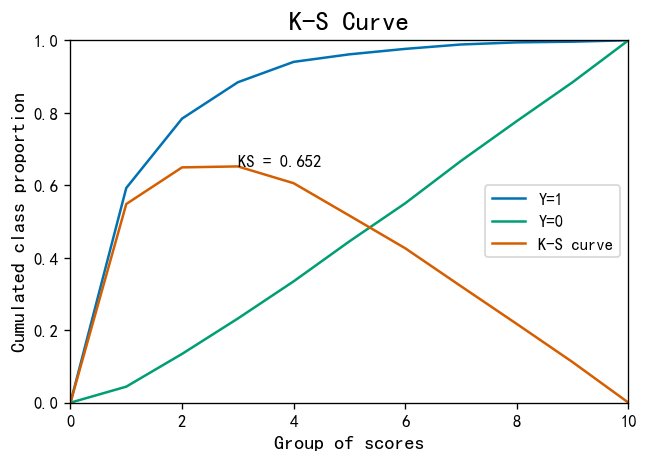

AUC: 0.9126749595837904


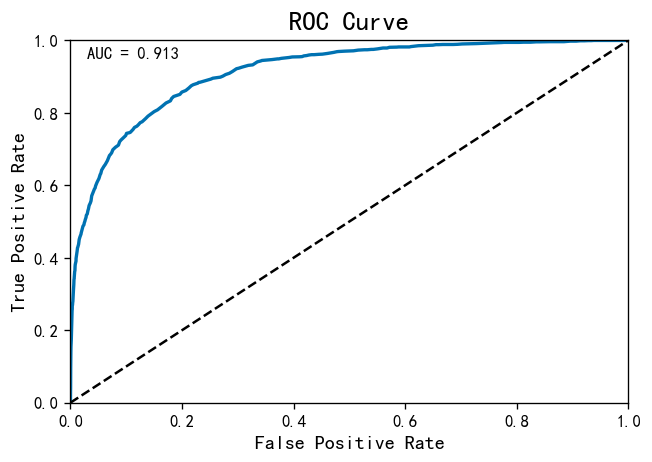

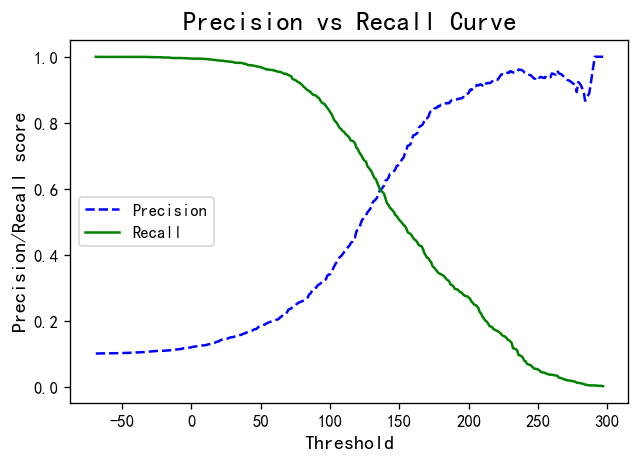

In [20]:
evaluation.plot_all()